## First estimate

Test to check the accuracy of an estimate based on the time of arrival only

In [1]:
import numpy as np
from matplotlib import pyplot as plt 
import utils

from rich.progress import track

# Load the dataset feeders
test_feeder = utils.data_feeder("splitted_dataset/test_splitted_data/").feed()
train_feeder = utils.data_feeder("splitted_dataset/train_splitted_data").feed()

### Plot the dataset

Text(0.5, 1.0, 'Time of arrival on detectors')

/home/djanloo/.local/share/virtualenvs/cmepda-VJ-vmc_S/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


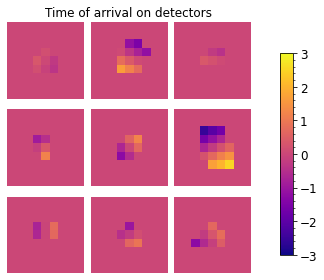

In [2]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True)
fig.subplots_adjust(wspace=-0.85, hspace=-0.25)

for i, ax in enumerate(axes.flatten()):
    image = ax.imshow(next(test_feeder)[0][i], cmap="plasma", vmin=-3, vmax=3)
    ax.axis('off')


cbar_ax = fig.add_axes([.85, 0.1, 0.03, 0.7])
fig.colorbar(image, cax=cbar_ax)
axes[0,1].set_title("Time of arrival on detectors")


Since the data manifest some sort of redundance (angle, height, dispersion angle and average speed give the t.o.a. matrix, 4 parameters to 81 observations)  an encoder network is tested

2022-06-23 20:20:03.690245: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 20:20:03.690280: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-23 20:20:07.060412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-23 20:20:07.060458: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-23 20:20:07.060484: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (djanloo-ratchet): /proc/driver/nvidia/version does not exist
2022-06-23 20:20:07.060755: I tensorflow/core/platform/cpu_fe

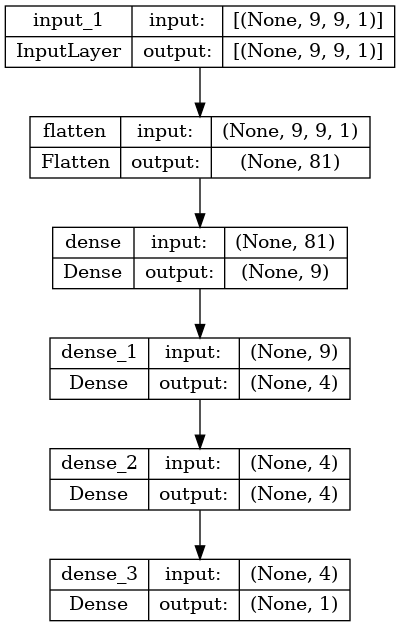

In [3]:
from keras import layers
from keras.models import Model
from keras.utils.vis_utils import plot_model

input = layers.Input(shape=(9, 9, 1))
layer = layers.Flatten()(input)
# layer = layers.Dense(81, activation="relu")(layer)
# y = layers.Dense(27, activation="relu")(layer)
# z = layers.Dense(27, activation="relu")(layer)
# minlayer = layers.Minimum()([y,z])
# maxlayer = layers.Maximum()([y,z])
# sublayer = layers.Subtract()([maxlayer, minlayer])
layer = layers.Dense(9, activation="relu")(layer) # change it to sublayer if not #
layer = layers.Dense(4, activation="relu")(layer)
layer = layers.Dense(4, activation="relu")(layer)
layer = layers.Dense(1)(layer)

retino = Model(input, outputs=layer)
retino.compile( optimizer="adam", 
                loss="mean_squared_error")

plot_model(retino, 
            show_shapes=True,
            show_layer_names=True)
# retino.summary()

In [4]:
for x,y in track(train_feeder, description="Training.."):
    retino.fit(
        x=x,
        y=y,
        epochs=50,
        batch_size=128,
        shuffle=True,
        verbose=0
    )


Output()

In [ ]:
errors = np.std( retino.predict(toa_test).squeeze() - y_test )/y_test*100
print(np.mean(errors))

938/938 [==============================] - 3s 3ms/step
6.740492084585221
